In [1]:
# load libs
# conda install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder 
import scipy.stats as stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
import xgboost as xgb

In [2]:
# load data
import os
from pathlib import Path 
Emission_data = Path(os.path.abspath(os.path.curdir)) / '2016_Building_Energy_Benchmarking.csv'
df = pd.read_csv(Emission_data)
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [3]:
# STAGE 1 - DATA CLEANING
# info of the dataset, different datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [4]:
# changing coma in the false object columns and transforming them to numerical
# Attention! the problem with comas appears while using Jupyter Cloud (fortunately no problem with Jupyter Desktop)
false_obj_cols=['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 
                'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 
                'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 
                'NaturalGas(therms)', 'NaturalGas(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']
df[false_obj_cols]=df[false_obj_cols].astype(str).apply(lambda x: x.str.replace(',',''))
df[false_obj_cols]=df[false_obj_cols].astype(float)

In [5]:
# checking false_obj_cols datatypes
df[false_obj_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PropertyGFATotal                 3376 non-null   float64
 1   PropertyGFAParking               3376 non-null   float64
 2   PropertyGFABuilding(s)           3376 non-null   float64
 3   LargestPropertyUseTypeGFA        3356 non-null   float64
 4   SecondLargestPropertyUseTypeGFA  1679 non-null   float64
 5   ThirdLargestPropertyUseTypeGFA   596 non-null    float64
 6   SiteEnergyUse(kBtu)              3371 non-null   float64
 7   SiteEnergyUseWN(kBtu)            3370 non-null   float64
 8   SteamUse(kBtu)                   3367 non-null   float64
 9   Electricity(kWh)                 3367 non-null   float64
 10  Electricity(kBtu)                3367 non-null   float64
 11  NaturalGas(therms)               3367 non-null   float64
 12  NaturalGas(kBtu)    

In [6]:
# draft inspection of nans share, the dataset needs nans treatment
round(df.isna().sum()/len(df)*100,2)

OSEBuildingID                        0.00
DataYear                             0.00
BuildingType                         0.00
PrimaryPropertyType                  0.00
PropertyName                         0.00
Address                              0.00
City                                 0.00
State                                0.00
ZipCode                              0.47
TaxParcelIdentificationNumber        0.00
CouncilDistrictCode                  0.00
Neighborhood                         0.00
Latitude                             0.00
Longitude                            0.00
YearBuilt                            0.00
NumberofBuildings                    0.24
NumberofFloors                       0.00
PropertyGFATotal                     0.00
PropertyGFAParking                   0.00
PropertyGFABuilding(s)               0.00
ListOfAllPropertyUseTypes            0.27
LargestPropertyUseType               0.59
LargestPropertyUseTypeGFA            0.59
SecondLargestPropertyUseType      

In [7]:
# checking Y columns (TotalGHGEmissions, Electricity(kWh))
# min values below 0 to be deleted to avoid confusion while modelling
df[['TotalGHGEmissions', 'Electricity(kWh)']].describe()

,TotalGHGEmissions,Electricity(kWh)
count,3367.000000,3.367000e+03
mean,119.723971,1.086639e+06
std,538.832227,4.352478e+06
min,-0.800000,-3.382680e+04
25%,9.495000,1.874229e+05
50%,33.920000,3.451299e+05
75%,93.940000,8.293178e+05
max,16870.980000,1.925775e+08


In [8]:
# dropping below 0 values for Y columns (TotalGHGEmissions, Electricity(kWh))
df=df.drop(df[(df['TotalGHGEmissions']<=0) | (df['Electricity(kWh)']<=0)].index)
df[['TotalGHGEmissions', 'Electricity(kWh)']].describe()

,TotalGHGEmissions,Electricity(kWh)
count,3352.000000,3.352000e+03
mean,119.864114,1.091512e+06
std,539.919209,4.361598e+06
min,0.090000,1.000000e+00
25%,9.617500,1.887342e+05
50%,34.010000,3.468170e+05
75%,93.905000,8.318078e+05
max,16870.980000,1.925775e+08


In [9]:
# deleting Id and non-informative columns for modelling
# OSEBuildingID, DataYear, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, YearsENERGYSTARCertified, DefaultData, Comments
non_inf_cols=['OSEBuildingID', 'DataYear', 'PropertyName', 'Address', 'City', 'State', 'Outlier',
              'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified', 'DefaultData', 'Comments']
df=df.drop(df[non_inf_cols],axis=1)

In [10]:
# checking ENERGYSTARScore before nans imputation for median (nans are not a unique class)
ENERGYSTARScore=pd.cut(df["ENERGYSTARScore"],[0,25,50,75,100])
df[df.ENERGYSTARScore.isna()][["TotalGHGEmissions"]].mean(), df.pivot_table("TotalGHGEmissions",ENERGYSTARScore)

(TotalGHGEmissions    141.837825
 dtype: float64,
                  TotalGHGEmissions
 ENERGYSTARScore                   
 (0, 25]                 236.794226
 (25, 50]                168.029356
 (50, 75]                110.375285
 (75, 100]                73.357438)

In [11]:
# splitting data into numerical and categorical
all_cols=list(df.columns)
num_cols=list(df._get_numeric_data().columns)
cat_cols=list(set(all_cols)-set(num_cols))
# round(df[cat_cols].isna().sum()/len(df[cat_cols])*100,2)
# round(df[num_cols].isna().sum()/len(df[num_cols])*100,2)

In [12]:
# checking numerical columns with many nans 
# no need for a separate treatment, to be changed by median later
num_cols_many_nans=df[num_cols].columns[df[num_cols].isna().sum()/len(df)>0.005]
num_cols_many_nans

Index(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore'],
      dtype='object')

In [13]:
# checking categorical columns with many nans 
# no need for a separate treatment, to be changed by the most frequent later
cat_cols_many_nans=df[cat_cols].columns[df[cat_cols].isna().sum()/len(df)>0.005]
cat_cols_many_nans

Index(['ThirdLargestPropertyUseType', 'SecondLargestPropertyUseType',
       'LargestPropertyUseType'],
      dtype='object')

In [14]:
# replacing nans for the numerical columns with nans by the medians
imputer_num = SimpleImputer(missing_values = np.nan,
                        strategy ='median')
df[num_cols]=imputer_num.fit_transform(df[num_cols])

In [15]:
# checking nans for the numerical columns
df[num_cols].isna().sum()

ZipCode                            0
CouncilDistrictCode                0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUI(kBtu/sf)                   0
SiteEUIWN(kBtu/sf)                 0
SourceEUI(kBtu/sf)                 0
SourceEUIWN(kBtu/sf)               0
SiteEnergyUse(kBtu)                0
SiteEnergyUseWN(kBtu)              0
SteamUse(kBtu)                     0
Electricity(kWh)                   0
Electricity(kBtu)                  0
NaturalGas(therms)                 0
NaturalGas(kBtu)                   0
TotalGHGEmissions                  0
GHGEmissionsIntensity              0
d

In [16]:
# replacing nans for the categorical columns with nans by the most frequent
imputer_cat = SimpleImputer(missing_values = np.nan,
                        strategy ='most_frequent')
df[cat_cols]=imputer_cat.fit_transform(df[cat_cols])

In [17]:
# checking nans for the categorical columns
df[cat_cols].isna().sum()

ThirdLargestPropertyUseType     0
PrimaryPropertyType             0
BuildingType                    0
Neighborhood                    0
ListOfAllPropertyUseTypes       0
SecondLargestPropertyUseType    0
ComplianceStatus                0
LargestPropertyUseType          0
dtype: int64

In [18]:
# dropping the columns with electricity and gas consumption data and GHGEmissionsIntensity
electr_cols=['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','SteamUse(kBtu)','Electricity(kBtu)']
# gas_cols=['NaturalGas(therms)','NaturalGas(kBtu)']
gas_cols=['NaturalGas(kBtu)']
df=df.drop(electr_cols,axis=1)
df=df.drop(gas_cols,axis=1)
df=df.drop('GHGEmissionsIntensity',axis=1)

In [19]:
# new splitting data into numerical and categorical
all_cols=list(df.columns)
num_cols=list(df._get_numeric_data().columns)
cat_cols=list(set(all_cols)-set(num_cols))

In [20]:
# implementing automatic Anova approach for treatment of the categorical columns
# defining a function to get the p_value
def p_test_cat(dataframe,col_x,col_y):
    cols=list(dataframe[col_x].value_counts().index) 
    results=[]
    for i in cols:
        i=dataframe[dataframe[col_x]==i][[col_y]]
        results.append(i)
    statistics, p_value=stats.f_oneway(*results)
    return p_value

In [21]:
# selecting the columns to delete (with p_value > 0.05) for TotalGHGEmissions
cols_to_drop=[]
for i in cat_cols:
    if p_test_cat(df,i,'TotalGHGEmissions')>0.05:
        cols_to_drop.append(i)
cols_to_drop

['Neighborhood', 'ComplianceStatus']

In [22]:
# selecting the columns to delete (with p_value > 0.05) for 'Electricity(kWh)
# the same columns except for Neighborhood 
cols_to_drop2=[]
for i in cat_cols:
    if p_test_cat(df,i,'Electricity(kWh)')>0.05:
        cols_to_drop2.append(i)
cols_to_drop2

['ComplianceStatus']

In [23]:
# dropping the categorical columns after p-test
df=df.drop(cols_to_drop2,axis=1)

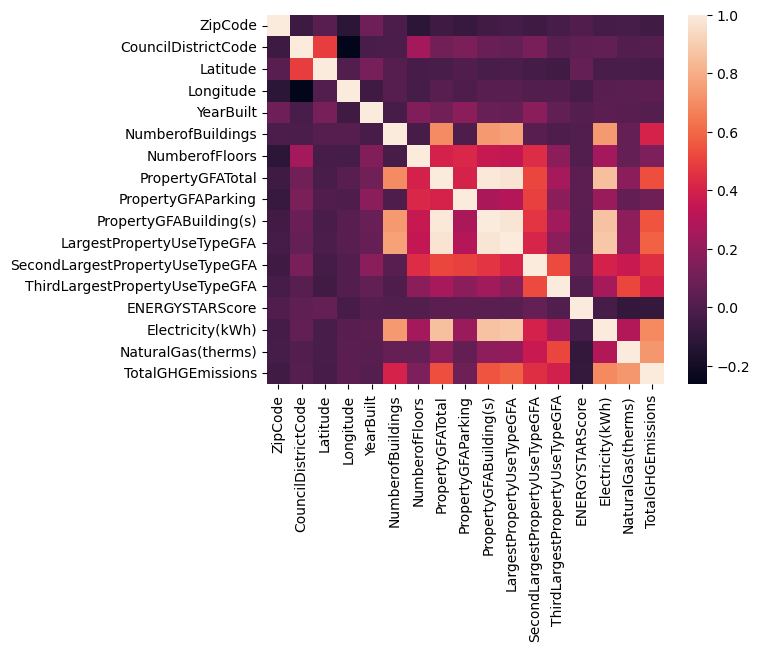

In [24]:
# building the correlation matrix for the numerical data to estimate correlations
corr=df[num_cols].corr()
sns.heatmap(data = corr,annot=False)
plt.show()

In [25]:
# selecting numerical columns with weak correlation (threshold < 0.5) to be deleted for TotalGHGEmissions
limit=0.5
corr_remove=corr[(corr["TotalGHGEmissions"]<limit)& (corr["TotalGHGEmissions"]>-limit)]
list_corr_remove=list(corr_remove.index)
list_corr_remove

['ZipCode',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore']

In [26]:
# selecting numerical columns with weak correlation (threshold < 0.5) to be deleted for Electricity(kWh)
limit=0.5
corr_remove2=corr[(corr["Electricity(kWh)"]<limit)& (corr["Electricity(kWh)"]>-limit)]
list_corr_remove2=list(corr_remove.index)
list_corr_remove2

['ZipCode',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore']

In [27]:
# two lists of columns with weak correlation are the same
set(list_corr_remove)-set(list_corr_remove2)

set()

In [28]:
# dropping the numerical columns with weak correlation
df=df.drop(list_corr_remove,axis=1)

In [29]:
# the resulting dataset after the previous stages of data cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3361 entries, 0 to 3375
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  3361 non-null   object 
 1   PrimaryPropertyType           3361 non-null   object 
 2   Neighborhood                  3361 non-null   object 
 3   PropertyGFATotal              3361 non-null   float64
 4   PropertyGFABuilding(s)        3361 non-null   float64
 5   ListOfAllPropertyUseTypes     3361 non-null   object 
 6   LargestPropertyUseType        3361 non-null   object 
 7   LargestPropertyUseTypeGFA     3361 non-null   float64
 8   SecondLargestPropertyUseType  3361 non-null   object 
 9   ThirdLargestPropertyUseType   3361 non-null   object 
 10  Electricity(kWh)              3361 non-null   float64
 11  NaturalGas(therms)            3361 non-null   float64
 12  TotalGHGEmissions             3361 non-null   float64
dtypes: 

In [30]:
# new splitting data into numerical and categorical after the previous stages of the cleaning
all_cols=list(df.columns)
num_cols=list(df._get_numeric_data().columns)
cat_cols=list(set(all_cols)-set(num_cols))

In [31]:
# implementing OrdinalEncoder for the categorical data
enc = OrdinalEncoder() 
df[cat_cols]= enc.fit_transform(df[cat_cols])

In [32]:
# all columns are clean and encoded
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3361 entries, 0 to 3375
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  3361 non-null   float64
 1   PrimaryPropertyType           3361 non-null   float64
 2   Neighborhood                  3361 non-null   float64
 3   PropertyGFATotal              3361 non-null   float64
 4   PropertyGFABuilding(s)        3361 non-null   float64
 5   ListOfAllPropertyUseTypes     3361 non-null   float64
 6   LargestPropertyUseType        3361 non-null   float64
 7   LargestPropertyUseTypeGFA     3361 non-null   float64
 8   SecondLargestPropertyUseType  3361 non-null   float64
 9   ThirdLargestPropertyUseType   3361 non-null   float64
 10  Electricity(kWh)              3361 non-null   float64
 11  NaturalGas(therms)            3361 non-null   float64
 12  TotalGHGEmissions             3361 non-null   float64
dtypes: 

In [33]:
# STAGE 2 - MODELLING
# before embarking on the modelling, it's recommended to make a perturbation of the dataset
# but in our case, due to small size of the dataset, I skipped this step
# dfr=pd.DataFrame(np.random.permutation(df.values),columns=df.columns)

In [34]:
# defining X and y (TotalGHGEmissions), yel (Electricity(kWh))
X=df.drop(["TotalGHGEmissions","Electricity(kWh)"],axis=1)
y=df[["TotalGHGEmissions"]]
yel=df[["Electricity(kWh)"]]

In [35]:
# Outliers removal
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
mask = yhat != -1
X,y,yel=X.loc[mask,:],y.loc[mask,:],yel.loc[mask,:]

In [36]:
# splitting data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [37]:
# splitting yel similar to y_train, y_test
_, _, yel_train, yel_test = train_test_split(X,yel,test_size = 0.2, random_state = 1)

In [38]:
# checking shapes 
y_train.shape,yel_train.shape,y_test.shape,yel_test.shape

((2421, 1), (2421, 1), (606, 1), (606, 1))

In [39]:
# scaling data for x, train and test (keeping logics of fitting and transforming)
scaler=StandardScaler()
X_sc=scaler.fit_transform(X)
X_tr=scaler.fit(X_train)
X_train_sc=X_tr.transform(X_train)
X_test_sc=X_tr.transform(X_test)

In [40]:
# additional stage to check multicollinearity among X columns
# the first three X variables have high multicollinearity (>5), thus they are highly mutually dependent
# keeping them won't deteriorate predictions, but may deteriorate features importance
X_mult=X_sc
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_sc, i)
                          for i in range(len(X.columns))]
  
print(vif_data.sort_values(by='VIF',ascending=False))

                         feature        VIF
3               PropertyGFATotal  32.014753
4         PropertyGFABuilding(s)  30.024982
7      LargestPropertyUseTypeGFA  16.285734
5      ListOfAllPropertyUseTypes   3.245122
6         LargestPropertyUseType   2.813769
1            PrimaryPropertyType   1.781032
8   SecondLargestPropertyUseType   1.394227
9    ThirdLargestPropertyUseType   1.267771
10            NaturalGas(therms)   1.263154
0                   BuildingType   1.200980
2                   Neighborhood   1.033399


In [41]:
# we deal with the regression problem, hence we'll use Regressors for modelling
y.describe(),yel.describe()

(       TotalGHGEmissions
 count        3027.000000
 mean           90.973247
 std           258.733714
 min             0.090000
 25%             9.650000
 50%            34.520000
 75%            90.630000
 max         10734.570000,
        Electricity(kWh)
 count      3.027000e+03
 mean       9.479874e+05
 std        2.498523e+06
 min        1.000000e+00
 25%        1.866692e+05
 50%        3.422759e+05
 75%        8.141756e+05
 max        8.046087e+07)

In [68]:
# set of different models to choose the best ones for further experiments (TotalGHGEmissions)
# SVM_opt - already optimized HPs for SVR model, since I saw that a linear algorythm works best
# due to small size of the dataset I utilize fit/predict method for train/test split instead of KFold
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVM', SVR()))
models.append(('SVM_opt', SVR(kernel="linear", gamma="auto")))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RandForrest', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('XGB', xgb.XGBRegressor()))

for name, model in models:
    model.fit(X_train_sc, np.ravel(y_train))
    y_predictions = model.predict(X_test_sc)
    r2 = np.corrcoef(np.ravel(y_test),np.ravel(y_predictions))[0,1]
    rmse=np.sqrt(mean_squared_error(np.ravel(y_test),np.ravel(y_predictions)))
    print('%s: %.2f (%.2f)' % (name, r2,rmse))

LR: 0.74 (109.45)
KNN: 0.69 (120.23)
SVM: 0.67 (121.57)
SVM_opt: 0.83 (79.43)
CART: 0.69 (115.21)
RandForrest: 0.89 (62.30)
GBR: 0.87 (67.85)
XGB: 0.84 (81.23)


In [55]:
# Hyperarameter (HP) Tuning to maximize performance of RF model (TotalGHGEmissions)    
n_estimators = [int(x) for x in np.linspace(200, 400, num = 5)] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(5, 15, num = 10)] # maximum number of levels allowed in each decision tree
max_features=[round(float(x),1) for x in np.linspace(0.1, 1, num = 10)]
# min_samples_leaf=[round(float(x),4) for x in np.linspace(0.0001, 0.002, num = 10)]

random_grid = {'n_estimators': n_estimators,
'max_depth': max_depth}
# 'max_features':max_features}
# 'min_samples_leaf':min_samples_leaf}

print ('Random grid: ', random_grid, '\n')

Random grid:  {'n_estimators': [200, 250, 300, 350, 400], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]} 



In [61]:
# initializing the model and running RF (TotalGHGEmissions)
rf_random = RandomizedSearchCV(RandomForestRegressor(), param_distributions = random_grid,
            verbose=1, random_state=1, n_jobs = -1, scoring="neg_mean_squared_error")
rf_random.fit(X_train_sc, np.ravel(y_train))
rf_best_params=rf_random.best_params_
print("Best parameters found: ", rf_random.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rf_random.best_score_)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'n_estimators': 200, 'max_depth': 12}
Lowest RMSE found:  235.5741537613917


In [62]:
# HP tuning hasn't improved the result due to small size of the dataset (TotalGHGEmissions)
rf_opt=RandomForestRegressor(**rf_best_params)
rf_opt.fit(X_train_sc, np.ravel(y_train))
y_predictions = rf_opt.predict(X_test_sc)
r2 = np.corrcoef(np.ravel(y_test),np.ravel(y_predictions))[0,1]
rmse=np.sqrt(mean_squared_error(np.ravel(y_test),np.ravel(y_predictions)))
print('R2 = %.2f' % (r2))
print('RMSE = %.2f' % (rmse))

R2 = 0.89
RMSE = 63.60


In [46]:
# this time I'll utilize SelectKBest to define a set of features that contribute the most to the model (TotalGHGEmissions)
# TOP 4 features: LargestPropertyUseTypeGFA, PropertyGFABuilding(s), PropertyGFATotal, NaturalGas(therms)
ft = SelectKBest(f_regression, k='all').fit(X_sc, np.ravel(y))
scores=np.round(ft.scores_,2)
summary_df=pd.DataFrame(data=scores,columns=['feature_importance'])
summary_df.index=X.columns
summary_df.sort_values(by='feature_importance',ascending=False)

,feature_importance
LargestPropertyUseTypeGFA,1323.25
PropertyGFABuilding(s),1044.99
PropertyGFATotal,941.43
NaturalGas(therms),823.27
BuildingType,21.98
PrimaryPropertyType,18.94
Neighborhood,17.92
ListOfAllPropertyUseTypes,6.69
ThirdLargestPropertyUseType,6.04
LargestPropertyUseType,0.47


In [47]:
# set of different models to choose the best ones for further experiments (Electricity(kWh)
# due to small size of the dataset I utilize fit/predict method for train/test split instead of KFold
for name, model in models:
    model.fit(X_train_sc, np.ravel(yel_train))
    y_predictions = model.predict(X_test_sc)
    r2 = np.corrcoef(np.ravel(yel_test),np.ravel(y_predictions))[0,1]
    rmse=np.sqrt(mean_squared_error(np.ravel(yel_test),np.ravel(y_predictions)))
    print('%s: %.2f (%.2f)' % (name, r2,rmse))

LR: 0.81 (1166294.57)
KNN: 0.82 (1107801.37)
SVM: 0.43 (2001866.07)
SVM_opt: 0.80 (1998763.16)
CART: 0.81 (1148341.34)
RandForrest: 0.86 (981892.66)
GBR: 0.79 (1296408.04)
XGB: 0.86 (1012122.08)


In [48]:
# finally I'll utilize Hyperarameter Tuning in order to set the optimal set of parameters to maximize performance 
# of the best model - XGB (Electricity(kWh)
n_estimators = [int(x) for x in np.linspace(100, 300, num = 5)] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(1, 12, num = 10)] # maximum number of levels allowed in each decision tree
colsample_bytree=[round(float(x),1) for x in np.linspace(0.5, 1, num = 8)]

xgb_param_grid = {
    'colsample_bytree':colsample_bytree,
    'n_estimators':n_estimators,
    'max_depth':max_depth}
xgb_random = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions = xgb_param_grid,
            verbose=1, random_state=1, n_jobs = -1, cv=2, scoring="neg_mean_squared_error")
xgb_random.fit(X_train_sc,np.ravel(yel_train))
xgb_best_params=xgb_random.best_params_
print(xgb_best_params)
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb_random.best_score_)))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
{'n_estimators': 250, 'max_depth': 7, 'colsample_bytree': 0.9}
Lowest RMSE found:  2007835.8771869345


In [49]:
# HP tuning improved R2 of the XGB model from 0.86 up to 0.88 (Electricity(kWh)
# Attention! the comparison is not correct due to small size of the dataset (I left it just as an example)
xgb_opt=xgb.XGBRegressor(**xgb_best_params)
xgb_opt.fit(X_train_sc, np.ravel(yel_train))
y_predictions = xgb_opt.predict(X_test_sc)
r2 = np.corrcoef(np.ravel(yel_test),np.ravel(y_predictions))[0,1]
rmse=np.sqrt(mean_squared_error(np.ravel(yel_test),np.ravel(y_predictions)))
print('R2 = %.2f' % (r2))
print('RMSE = %.2f' % (rmse))

R2 = 0.88
RMSE = 950769.28


In [50]:
# this time I'll utilize SelectKBest to define a set of features that contribute the most to the model (Electricity(kWh)
# TOP 3 features: PropertyGFATotal, PropertyGFABuilding(s), LargestPropertyUseTypeGFA
ft = SelectKBest(f_regression, k='all').fit(X_sc, np.ravel(yel))
scores=np.round(ft.scores_,2)
summary_df=pd.DataFrame(data=scores,columns=['feature_importance'])
summary_df.index=X.columns
summary_df.sort_values(by='feature_importance',ascending=False)

,feature_importance
PropertyGFATotal,2220.70
PropertyGFABuilding(s),2164.34
LargestPropertyUseTypeGFA,2091.47
NaturalGas(therms),195.70
ThirdLargestPropertyUseType,77.00
BuildingType,36.62
Neighborhood,26.74
PrimaryPropertyType,13.97
SecondLargestPropertyUseType,13.25
ListOfAllPropertyUseTypes,12.00
